# Configuration

In [61]:
import random
import math

import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

In [62]:
random.seed(0)
np.random.seed(0)
cv.setRNGSeed(0)

In [63]:
img1_path = 'translation_dataset/graff-1.png'

# img2_path = 'translation_dataset/graff-2-identical.png'  # easiest problem
# img2_path = 'translation_dataset/graff-2-translated.png'
# img2_path = 'translation_dataset/graff-2-occluded-translated.png'
img2_path = 'translation_dataset/graff-2-noisy-occluded-translated.png'  # hardest problem (actually even this one is very easy)

# Parameters for keypoint detection
keypoint_size = 21  # Our own keypoint detector depends on this single parameter. (There is no such parameter normally.)

# Parameters for descriptor extraction
descriptor_size = 9  # Our own descriptor extractor depends on this single parameter. (There is no such parameter normally.)

# Parameters for matching
cross_check = True  # This is a parameter related to how the descriptors are matched. This is also a part of OpenCV's matchers. cross_check=True is usually good.

# Parameters for outlier removal
iteration_count = 1000  # This is a parameter that determines how long the RANSAC algorithm runs (i.e. searches the inliers). This is also a part of OpenCV's matchers. Higher iteration_count has higher chance of finding the inliers but it also takes longer.
threshold = 3  # This many pixels is the maximum allowed error for a match to be considered an inlier. If low, then we will have fewer but higher quality (i.e. less noisy) matches after outlier removal. Probably keep it at 3 pixels. (3 is the OpenCV's default value as well.)


# Utilities

In [64]:
def read_image(path, is_grayscale=False):
    if is_grayscale:
        return cv.imread(path, cv.IMREAD_GRAYSCALE)
    else:
        return cv.imread(path, cv.IMREAD_COLOR)

In [65]:
def show_image(img):
    if len(img.shape) == 2:
        plt.imshow(img, cmap='gray')
    else:
        assert len(img.shape) == 3 and img.shape[2] == 3
        plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    plt.show()

# Images

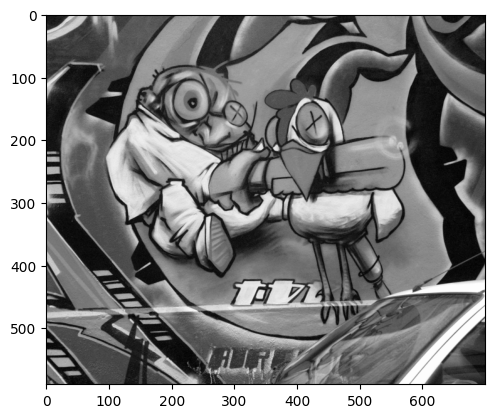

In [66]:
img1 = read_image(img1_path, is_grayscale=True)
show_image(img1)

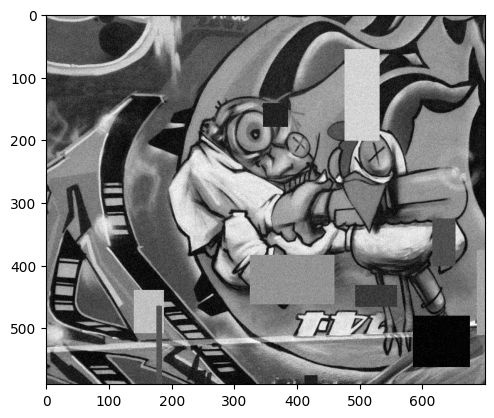

In [67]:
img2 = read_image(img2_path, is_grayscale=True)
show_image(img2)

# Keypoints

In [68]:
# Keypoints of an image are like "distinct" points (e.g. corners of things).
# KeyPoint is a simple alternative to cv.KeyPoint.
# In our case, keypoints are not different than points.
# Because our keypoint detectors are very simple, they just keep the (x, y) coordinates of the keypoints.
# But in general, keypoints are points with additional information.
# cv.KeyPoint has attributes such as size (diameter of the keypoint), angle (orientation), response (strength of the keypoint), etc.
# We use keypoint.x and keypoint.y to access the coordinates of a KeyPoint.
# They use keypoint.pt[0] and keypoint.pt[1] to access the coordinates of a cv.KeyPoint.
class KeyPoint:

    def __init__(self, x, y) -> None:
        self.x = x
        self.y = y


# This is a very simple keypoint detector.
# Useless in most cases. (It will not work if there are scale difference or rotation between images.)
# The main requirement for a keypoint detector is that these keypoints should be repeatable.
# (If we detect a point in one image, we should be able to detect the corresponding point on the other image.)
# (Perfectly repeatable keypoints are impossible. So there will be keypoints whose correspondences were not found.) 
def detect_keypoints(img, size=21):
    # img is a grayscale image (a numpy array of shape (H, W) with values in [0, 255])
    # Detects all points that is a local extrema.
    # Returns a list of (x, y) coordinates of the detected points.

    assert isinstance(img, np.ndarray), 'img must be a numpy array'
    assert len(img.shape) == 2, 'img must be grayscale'
    assert img.dtype == np.uint8, 'img must be of type np.uint8'

    assert isinstance(size, int), 'size must be an integer'
    assert size % 2 == 1, 'size must be odd'

    half = size // 2
    h, w = img.shape

    def is_center_local_extrema(square):
        # square is a numpy array of shape (size, size)
        # Returns True if the center of the square is a local extrema.
        # Returns False otherwise.

        # Asagida square'in orta noktasi diger noktalarindan daha buyuk veya daha kucuk mu diye bakiyoruz.
        # Belki daha elegant bir sekilde yazilabilir, aklima gelmedi.
        center = square[half, half]
        square = square.copy()
        square[half, half] = 255  # effectively remove the center pixel (maximum of uint8)
        if center < np.min(square):
            return True
        else:
            square[half, half] = 0  # effectively remove the center pixel (minimum of uint8)
            return center > np.max(square)


    kp_list = []
    for x in range(half, w - half):  # x is column!
        for y in range(half, h - half):  # y is row!
            square = img[y-half:y+half+1, x-half:x+half+1]  # size x size neighborhood of (x, y)
            if is_center_local_extrema(square):
                kp_list.append(KeyPoint(x, y))

    
    return kp_list

In [69]:
def draw_keypoints(img, kp):
    img = cv.cvtColor(img, cv.COLOR_GRAY2BGR)  # Hem kopyalamis oluyoruz hem de 3 kanala cikarmis oluyoruz. (Yoksa renkli circle cizilmez.)
    color = (0, 0, 255)  # Red
    for keypoint in kp:
        cv.circle(img, (int(keypoint.x), int(keypoint.y)), 3, color, -1)
    return img

Keypoint count (img1): 607


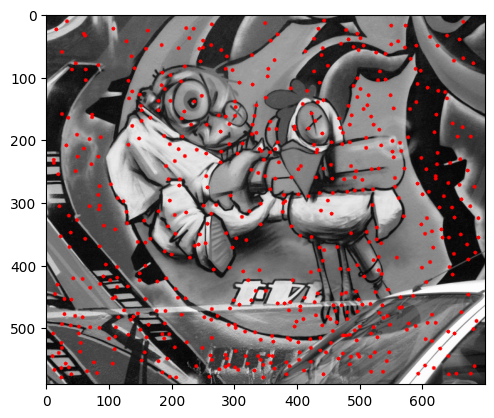

In [70]:
kp1 = detect_keypoints(img1, size=keypoint_size)

print('Keypoint count (img1):', len(kp1))
show_image(draw_keypoints(img1, kp1))

# Detected keypoints look good. Because:
# There are many of them. (Normally we have some thousands of keypoints. But translation is an easy problem.)
# They are distributed all over the image (i.e. they cover the image well).
# They are not too close to each other. 
#   With this simple algorithm we can always increase the size to make keypoints more sparse (i.e. far away from each other).
#   But in general we use non-maximum suppression to remove some of the overlapping keypoints. 
#   (See Google images for non-maximum suppression. You will see examples for "object detection" problem. But "keypoint detection" is similar.)

Keypoint count (img2): 776


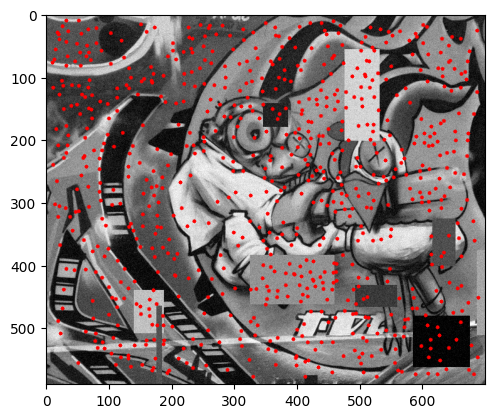

In [71]:
kp2 = detect_keypoints(img2, size=keypoint_size)

print('Keypoint count (img2):', len(kp2))
show_image(draw_keypoints(img2, kp2))

# Descriptors

In [72]:
def describe_features(img, kp, size=15):
    assert size % 2 == 1, 'size must be odd'

    # img is a grayscale image (a numpy array of shape (H, W) with values in [0, 255])
    # kp is list[KeyPoint] and KeyPoint has x and y.
    # return a numpy array of shape (N, 5) with values in [0, 1]

    half = size // 2

    des_list = []
    for keypoint in kp:
        x = keypoint.x
        y = keypoint.y
        if x < half or x >= img.shape[1] - half or y < half or y >= img.shape[0] - half:
            assert False, 'keypoint is too close to the boundary'

        des = img[y - half:y + half + 1, x - half:x + half + 1].flatten()
        des_list.append(des)

    #for des in des_list:
    #    des = des / np.linalg.norm(des)

    des = np.stack(des_list, axis=0)
    # des = des / 255.0
    # Make sure all the rows are unit vectors (i.e. all the descriptors are unit vectors)
    # Otherwise calculating distance between them requires calculating angle (rather than Euclidean distance)
    des = des / np.linalg.norm(des, axis=1, keepdims=True)

    return des


In [73]:
des1 = describe_features(img1, kp1, size=descriptor_size)
des2 = describe_features(img2, kp2, size=descriptor_size)

# Matches

In [74]:
# OpenCV has cv.DMatch class.
class Match:

    def __init__(self, idx1, idx2, distance) -> None:
        self.idx1 = idx1  # This is called "queryIdx" in OpenCV's terminology.
        self.idx2 = idx2  # This is called "trainIdx" in OpenCV's terminology.
        self.distance = distance  # We will store this but not use it.


def calc_distance(descriptor1, descriptor2):
    return np.linalg.norm(descriptor1 - descriptor2)  # This is actually the Euclidean distance.


def match_features(des1, des2, cross_check=True):
    # des1 and des2 are numpy arrays of descriptors.
    # Each row of des1 and des2 is a descriptor.
    # Find the best match (using Euclidean distance) in des2 for each descriptor in des1.

    # cross_check mantikli cunku bircok feature repeatable olmayacak.

    match_list = []
    
    if not cross_check:
        for i in range(len(des1)):
            min_dist = float('inf')
            min_idx = None
            for j in range(len(des2)):
                dist = calc_distance(des1[i], des2[j])
                if dist < min_dist:
                    min_dist = dist
                    min_idx = j
            assert min_idx is not None
            match_list.append(Match(i, min_idx, min_dist))

    else:
        for i in range(len(des1)):
            min_dist = float('inf')
            min_idx = None
            for j in range(len(des2)):
                dist = calc_distance(des1[i], des2[j])
                if dist < min_dist:
                    min_dist = dist
                    min_idx = j
            assert min_idx is not None
            # Find the best match of des1[i] in des2.
            # Then, find the best match of des2[min_idx] in des1.
            # If the best match of des2[min_idx] is des1[i], then add (i, min_idx) to match_list.
            min_dist2 = float('inf')
            min_idx2 = None
            for k in range(len(des1)):
                dist2 = calc_distance(des2[min_idx], des1[k])
                if dist2 < min_dist2:
                    min_dist2 = dist2
                    min_idx2 = k
            assert min_idx2 is not None
            if min_idx2 == i:
                match_list.append(Match(i, min_idx, min_dist))

    return match_list

In [75]:
matches = match_features(des1, des2, cross_check=cross_check)
print('Keypoint count (img1):', len(kp1))
print('Keypoint count (img2):', len(kp2))
print('Match count:', len(matches))

Keypoint count (img1): 607
Keypoint count (img2): 776
Match count: 152


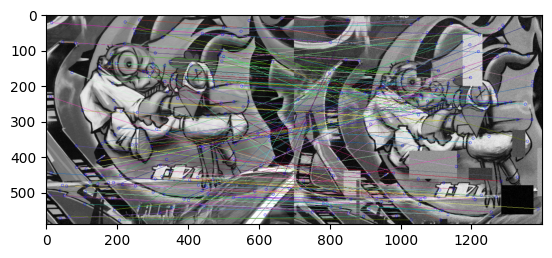

In [76]:
def draw_matches(img1, img2, kp1, kp2, matches, n=None):
    # Concatenate images
    img_matches = np.concatenate((img1, img2), axis=1)
    img_matches = cv.cvtColor(img_matches, cv.COLOR_GRAY2BGR)

    if n is not None:
        matches = matches.copy()
        random.shuffle(matches)
        matches = matches[:n]

    # Draw matches
    for match in matches:
        # Get the matching keypoints for each of the images
        img1_idx = match.idx1
        img2_idx = match.idx2

        # x - columns
        # y - rows
        (x1, y1) = kp1[img1_idx].x, kp1[img1_idx].y 
        (x2, y2) = kp2[img2_idx].x, kp2[img2_idx].y

        # Draw a small circle at both co-ordinates and then draw a line
        color = tuple(np.random.randint(0, 255, 3).tolist())
        cv.circle(img_matches, (int(x1), int(y1)), 4, (255, 0, 0), 1)
        cv.circle(img_matches, (int(x2) + img1.shape[1], int(y2)), 4, (255, 0, 0), 1)
        cv.line(img_matches, (int(x1), int(y1)), (int(x2) + img1.shape[1], int(y2)), color, 1)

    return img_matches


show_image(draw_matches(img1, img2, kp1, kp2, matches, n=None))

# Estimation (Estimation without outlier filtering)

In [81]:
# Normally we work with a homography. But we do not have a class named Homography.
# A homography is a 3x3 matrix (np.ndarray).
# Its inverse is calculated as np.linalg.inv(homography).
class Translation:

    def __init__(self, tx, ty):
        self.tx = tx
        self.ty = ty

    # We will not use this method.
    # If there is translation t from img1 to img2, then there is t.inverse() from img2 to img1.
    def inverse(self):
        return Translation(-self.tx, -self.ty)


# This is a minimal solver.
# Minimal solver means that it solves the problem (i.e. estimates the transformation) but it only uses a minimal set of point correspondences.
def get_translation(x1, y1, x2, y2):
    # Estimate the transformation given minimal set of 2D point correspondences.
    # (Only 1 correspondence is needed for translation.)
    # (x1, y1) is transformed to (x2, y2). What is the transformation?
    # x1 + tx = x2
    # y1 + ty = y2
    # 2 bilinmeyen var. 2 denklem var (1 eslesme var). Coz.
    # (Homografide 8 bilinmeyen ve 8 denklem (4 eslesme var) olacak.)
    tx = x2 - x1
    ty = y2 - y1
    return Translation(tx, ty)


# This is a solver. (Not a minimal solver.)
def estimate_parameters(matches, kp1, kp2):
    # kp1[matches[0].idx1] is transformed to kp2[matches[0].idx2]. 
    # kp1[matches[1].idx1] is transformed to kp2[matches[1].idx2].
    # kp1[matches[2].idx1] is transformed to kp2[matches[2].idx2].
    # ...
    # What is the transformation? 
    # (Probably no transformation perfectly transforms all these points, 
    # because errors are expected in the given point correspondences,
    # but we need to find the transformation that explains the data the best.)
    # (If there was no error in the given point correspondences, then we could use the minimal solver with only 1 correspondence.)

    # Note that this function works with localization errors (i.e. inliers). (e.g. kp1[matches[0].idx1] is indeed APPROXIMATELY transformed to kp2[matches[0].idx2].)
    # But it does not work with matching errors (i.e. outliers). (e.g. kp1[matches[0].idx1] is actually transformed to FAR AWAY from kp2[matches[1].idx2].)
    # So probably remove outliers before calling this function.

    tx_list = []
    ty_list = []
    for m in matches:
        keypoint1 = kp1[m.idx1]
        keypoint2 = kp2[m.idx2]
        translation = get_translation(keypoint1.x, keypoint1.y, keypoint2.x, keypoint2.y)
        tx_list.append(translation.tx)
        ty_list.append(translation.ty)
    tx_mean = np.mean(tx_list)  # np.median alabiliriz ve iyi bulur. Bu da zaten outlierlardan etkilenmemenin yolu. Ama translation otesinde boyle bir mantik yok.
    ty_mean = np.mean(ty_list)  # Ustteki gibi.
    return Translation(tx_mean, ty_mean)


simply_estimated_translation = estimate_parameters(matches, kp1, kp2)
print('Match count (All matches are considered):', len(matches))
print('Estimated parameters:', round(simply_estimated_translation.tx, 2), 'and', round(simply_estimated_translation.ty, 2))
# There are outliers in matches. So the estimation is not good.

Match count (All matches are considered): 152
Estimated parameters: 39.88 and -10.81


# Robust Estimation (Estimation with outlier filtering)

Inlier count: 47
Estimated parameters: 99.98 and 49.98


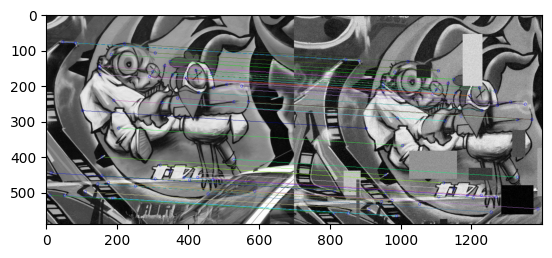

In [78]:
def euclidean_distance(x1, y1, x2, y2):
    return ((x1 - x2) ** 2 + (y1 - y2) ** 2) ** 0.5


def translate(x, y, translation):
    # Transform given keypoint using given translation.
    # If we need it, we can use this function for inverse translation as well.
    # Forward translation: estimated_x2, estimated_y2 = translate(x1, y1, Translation(tx, ty))
    # Inverse translation: estimated_x1, estimated_y1 = translate(x2, y2, Translation(-tx, -ty))
    translated_x = x + translation.tx
    translated_y = y + translation.ty
    return translated_x, translated_y


def geometric_distance(x1, y1, x2, y2, translation):
    # We implement "transfer error".
    # See "Error in one image" from Multiple View Geometry in Computer Vision, 2nd Edition, page 94.
    # Euclidean distance between real (x2, y2) and estimated (x2, y2), which is translated (x1, y1).
    estimated_x2, estimated_y2 = translate(x1, y1, translation)
    return euclidean_distance(x2, y2, estimated_x2, estimated_y2)


def filter_outliers(matches, kp1, kp2, threshold=3, iteration_count=1000):
    # This is a simple RANSAC filter that removes matches that are outliers.
    # See https://youtu.be/EkYXjmiolBg

    best_inlier_list = []
    # best_translation_hypothesis = None
    for _ in range(iteration_count):

        # Generate a random hypothesis about our transformation
        random_match = random.choice(matches)  # Correspondence sampling. 1 match is enough for translation estimation.
        keypoint1_of_random_match = kp1[random_match.idx1]
        keypoint2_of_random_match = kp2[random_match.idx2]
        translation_hypothesis = get_translation(keypoint1_of_random_match.x, keypoint1_of_random_match.y, keypoint2_of_random_match.x, keypoint2_of_random_match.y)

        # Find inliers (i.e. matches that are (sufficiently) consistent with our hypothesis)
        inlier_list = []
        for match in matches:
            keypoint1 = kp1[match.idx1]
            keypoint2 = kp2[match.idx2]

            error = geometric_distance(keypoint1.x, keypoint1.y, keypoint2.x, keypoint2.y, translation_hypothesis)
            if error < threshold:
                inlier_list.append(match)

        # Keep track of the largest set of inliers (It is probably the best hypothesis we have generated so far)
        if len(inlier_list) > len(best_inlier_list):
            best_inlier_list = inlier_list
            # best_translation_hypothesis = translation_hypothesis

    # We may also return the best hypothesis, but it is not that useful.
    # It should be good but we can find better now.
    # We can make a better estimation using all the inliers we found.

    # Butun bu surec suna benziyor (once parantez iclerini okumadan oku): 
    # 100 kisilik bir grubumuz var. (100 yerine len(matches) ve insan yerine match)
    # Eyfel kulesinin yuksekligini tahmin etmek istiyoruz. (Eyfel kulesinin yuksekligi yerine translation)
    # Herkesin bir tahmini var. (Her match'in bir translation tahmini var. get_translation ile bu tahmin yapiliyor.)
    # Tabii bu tahminlerden kimisi iyi (cevabi asagi yukari bilenler veya sanslarina tutturanlar, bunlar inlier), kimisi kotu (bunlar outlier).
    # Biz herkesin tahmininin ortalamasini alabiliriz kolayca. 
    # outlier_filtering yapmadan estimate_parameters cagirmak da aslinda buydu.
    # Ancak outlierlar bizim tahminimizi cok kotu etkilerler.
    # Mesela birileri gidip 1000 metre falan diyebilir.
    # Biz burada outlier_filtering'i soyle yapiyoruz:
    # 1000 defa veya vaktin ne kadar varsa tekrarla: 
    #   Rastgele bir kisinin tahminini hipotez olarak al.
    #   Bu kisiye yakin tahminde bulunanlarin yani inlierlarin listesini cikar.
    #   Bu liste simdiye kadar bulunan en genis inlier listesiyse (yani tahmin simdiye kadarki en iyi hipotezse) bu listeyi kaydet.
    # En son en genis listeyi dondur.

    # Burada onemli olan bir sey su: En iyi tahminimiz sadece en cok kisinin tahminini etrafinda toplayan tahmin.
    # Bu tahmin iyi bir tahmin ama daha iyisini yapabiliriz.
    # Inlierlarin hepsinin ortalamasini alarak daha iyi bir tahmin yapabiliriz.
    # Iste bu yuzden buldugumuz en iyi hipotezin bir onemi yok.
    # Butun bu inlierlari kullanarak daha iyi bir tahmin yapacagiz bu fonksiyondan ciktiktan sonra. (estimate_parameters)

    # Ayrinti: 
    # Eger amac Eyfel kulesinin yuksekligini tahmin etmekse veya tx, ty gibi tek bir match'ten cikarilabilecek bir seyi tahmin etmekse
    # aslinda buradakinden daha etkili yontemler bulunabilir. Mesela noktalar uzayda isaretlenip clustering denenebilir. Biz bu RANSAC 
    # yaklasimini homografi tahmini gibi daha karmasik problemlere uygulayabilmek icin ogreniyoruz. Oralarda clustering pek mumkun degil.
    # Cunku 4 match'ten bir homografi hesaplanabiliyor ve match'lerin 4'lu tum kombinasyonlarindan elde edilen homografileri uzayda cizip
    # benzer olanlari kumelemek hic de pratik degil! Diger yaklasimlara (ve daha gelismis RANSAC'lere) The Maximum Consensus Problem isimli 
    # kitaptan veya https://cmp.felk.cvut.cz/cvpr2020-ransac-tutorial adresindeki videolardan bakilabilir. (Ileri duzey!)

    return best_inlier_list


inlier_matches = filter_outliers(matches, kp1, kp2, threshold=threshold, iteration_count=iteration_count)
print('Inlier count:', len(inlier_matches))
# These matches are called inliers. But a better name would be "consensus set", a set of matches that are consistent with each other.
# (The largest set of matches we have found so far that all agree on the transformation parameters tx and ty.)
# They are inlier to each other. They are not necessarily inlier to the ground truth.

show_image(draw_matches(img1, img2, kp1, kp2, inlier_matches, n=None))
estimated_translation = estimate_parameters(inlier_matches, kp1, kp2)
print('Estimated parameters:', round(estimated_translation.tx, 2), 'and', round(estimated_translation.ty, 2))

# Evaluation

In [79]:
ground_truth_translation = Translation(100, 50)

def calculate_error(estimated_translation, ground_truth_translation):
    return euclidean_distance(estimated_translation.tx, estimated_translation.ty, ground_truth_translation.tx, ground_truth_translation.ty)

error = calculate_error(estimated_translation, ground_truth_translation)
print('Error: ', round(error, 3), 'pixels')

# Normally we don't have access to the ground truth transformation, so we can't calculate the error.
# Thus we use the number of inliers as a measure of the quality of the estimated translation.
# If it is above a certain threshold, we accept the estimated translation (and hope that we are right).
# For example, one of the possible configurations gave us 152 matches. 47 of them were found to be inliers.
# The error threshold for outlier filtering was reasonabably low (3 pixels). 
# So it is very unlikely that 47 consistent matches were found by chance.
# If the estimated translation was totally wrong, we would have found only a few consistent matches.

Error:  0.03 pixels


# Exercises (Translation Estimation)

In these exercises you will modify the code above.

## Exercise 1 (trivial)

- Add response to keypoints. (e.g. absolute difference between the intensity at (x,y) and the second extreme intensity in the neighborhood)
- So the KeyPoint class will include an attribute called 'response'.
- Use these values to filter keypoints. (e.g. we only want 100 top features: detect_keypoints(img1, n=100, size=keypoint_size))
- First, detect all keypoints. Then choose top n ones. (You can sort them. And choose the first (or last) n of them. But you can do this more efficiently!) See https://en.m.wikipedia.org/wiki/Partial_sorting
- Why would we want to use 100 keypoints only? To speed up the matching process!
- Without responses, we can select 100 keypoints randomly. But of course this is suboptimal. We should choose 100 best keypoints.

## Exercise 2 (easy)

- Add ratio test to match_features. (e.g. use 0.7)
- We should be able to use any combination of cross_check and ratio_test.

## Exercise 3 (easy)

You know the ground truth translation, which is tx=100, ty=50. So you can calculate the true inlier ratio in a match list (Before outlier filtering!). You can use threshold=3 for errors (i.e. if the translation for a particular match is tx=101, ty=50 then this is an inlier because the transfer error is euclidean_distance(101, 50, 100, 50) = 1 which is less than 3).

- Determine inlier ratio for different settings.
  - For example, for keypoint_size=21, descriptor_size=9, cross_check=True.
  - cross_check=True should usually increase the inlier ratio at the cost of reducing the number of matches. (So you have fewer but better matches. This is sometimes good and sometimes bad. Usually good.)
  - Set cross_check=False and use different ratios for ratio test (such as 0.1, 0.2, ..., 1.0). Draw two line plots using matplotlib:
    - (1) x axis is the ratio for the ratio test, y axis is the inlier ratio. (We want this number as high as possible. Otherwise the outlier filtering will take so much time!)
    - (2) x asis is the ratio for the ratio test, y axis is the number of inliers. (We want this number to be sufficiently high. In practise for a translation estimation, only one inlier match should be enough. But in that case we cannot know which one is the inlier since this inlier does not have any support from other matches (i.e. other matches which suggest similar transformation parameters). Plus, inlier matches are noisy, meaning that small localization errors are expected even for the inliers (Hence we have threshold=3). So we need more matches to remove the noise. In practice, for an accurate translation estimation, 4-5 inlier matches may be enough. When we perform homography estimation, we need at least 15-20 inlier matches.)

In practive the inlier ratio can be as low as 10% or even lower. But RANSAC-like robust estimators are usually able to filter the outliers! (Robust estimation means that you can estimate your parameters without getting affected by the outliers.)

How? Because this 10% of matches more or less agree on the same transformation parameters (i.e. they have a "consensus" on the parameters; because they are correct and correctness cannot be random; e.g. one says tx=99.5, ty=50.4, another one says tx=100.1, ty=49.9, which is almost the same thing) but other 90% totally disagree with each other (because they are wrong and errors are random; e.g. one says tx=30, ty=-15, another one says tx=-34, ty=74, which are totally different things).

A real life example may be this: Let's say there are 30 political parties competing against each other to win an election. These parties fall into two categories: red opinion and blue opinion. They are named red, blue1, blue2, blue3, ..., blue 29. Let's say only 10% of people vote for red, other 90% of people vote for a random blue party. Even though they represent a minority, red party will probably have the largest consensus and get the most votes. (Another and actually a better example was given as a comment inside filter_outliers.)

## Exercise 4 (medium)

- Use OpenCV's SIFT for detecting keypoints and describing features.
- See SIFT: https://docs.opencv.org/4.x/da/df5/tutorial_py_sift_intro.html 
- Recommended: https://www.analyticsvidhya.com/blog/2019/10/detailed-guide-powerful-sift-technique-image-matching-python
- We do not need our own KeyPoint implementation anymore. You will work with cv.KeyPoint. See https://docs.opencv.org/4.x/d2/d29/classcv_1_1KeyPoint.html

Understand how it generally works (But not the details):

- Watch this to understand SIFT a little bit: https://youtu.be/4AvTMVD9ig0
- Also watch this (it visualizes the process): https://youtu.be/ram-jbLJjFg
- You won't understand the details! Don't worry.
- The most important thing about keypoint detectors and feature descriptors is whether they are scale-invariant and rotation-invariant.
  - 'something-invariant' means when you change 'something', the results don't change.
  - So if your features are scale-invariant, even if there is a scale difference between your images, you should be able to detect the same keypoints and describe the features very similarly.
  - SIFT is almost scale-invariant (it resizes the images (see 'image pyramid') and detect keypoints!) and almost rotation-invariant (it calculates the dominant orientation (an angle), and describe the patch relative to this angle).
  - There are these geometric changes (e.g. different scales) but also photometric changes (e.g. different brightnesses) between images.
    - Photometric changes include many other things: one image may be darker (photo taken at night), blurred, etc.
    - It is important that our algorithms are not affected by these changes much.

## Exercise 5 (medium)

- We already have an implementation of "transfer error".
- Implement "symmetric transfer error" and "reprojection error" inside geometric_distance.
- See Multiple View Geometry in Computer Vision, 2nd Edition, page 94 and 95, and also Fig. 4.2.
- The class Translation has a method named inverse. Use it.
- We should be able to select any of these three errors when we call geometric_distance.
- Try all and observe the results. (Which one is the best if there is any difference?)

# Homework: Warmup for Homography Estimation

## Homework 1 (easy)

- The ground truth homography matrices between homography_dataset/img1.png and other images are given as homography_dataset/H1to2p etc.
- Create a new script to calculate and save other ground truth homography matrices (e.g. H1to1, H3to5, H5to1, etc.).
- You need to run this code only once.
- In total there should be 36 ground truth homography matrices.
- How? Read notes/homework1_hint.txt if you really need a hint! (Otherwise don't!)
- You can use cv.warpPerspective to warp images to manually check if you calculated the homography matrices correctly.
- For example if you warp img3.png using H3to4, you should get something similar to img4.png. 

# Homework: Homography Estimation using OpenCV and Kornia

## Homework 2 (medium)

- Create a new Jupter Notebook.
- Rewrite the code using OpenCV's BFMatcher and findHomography (with method=cv.RANSAC).
- This is your best friend when you work with OpenCV: https://docs.opencv.org/4.x/ 
  - Pay extra attention to the modules named 'features2d' (for features) and 'calib3d' (for estimation).  
- You are already using SIFT. Now use BFMatcher and findHomography.
- See BFMatcher (SIFT included): https://docs.opencv.org/4.x/dc/dc3/tutorial_py_matcher.html
  - Try crossCheck (given as argument to the constructor) and ratio test (using knnMatch with k=2 and then eliminating some) as well.
    - A match will be represented with a cv.DMatch object. See https://docs.opencv.org/4.x/d4/de0/classcv_1_1DMatch.html
    - queryIdx is like idx1, trainIdx is like idx2. MEMORIZE IT!
  - imgIdx is not important.
- See findHomography (SIFT and BFMatcher included): https://docs.opencv.org/4.x/d1/de0/tutorial_py_feature_homography.html
  - Try method=0 (no outlier filtering) and method=cv.RANSAC (outlier filtering using simple RANSAC; relatively simple but still more advanced than our implementation).

## Homework 3 (medium)

- Instead of using SIFT, try these:
  - RootSIFT (simple post-processing for SIFT): RootSIFT is usually better than SIFT. Google something like OpenCV RootSIFT.
  - ORB (For BFMatcher, you need to change the normType to cv.NORM_HAMMING): ORB is faster (but worse) than SIFT.
  - You can also try newer feature extractors defined in 'xfeatures2d' module (e.g. BEBLID). See https://docs.opencv.org/4.x/d7/d7a/group__xfeatures2d__experiment.html
- Instead of BFMatcher, try this:
  - FlannBasedMatcher: FLANN is faster (but worse) than BFMatcher.
  - You can also try newer feature matches defined in 'xfeatures2d' module (e.g. GMS): See https://docs.opencv.org/4.x/db/dd9/group__xfeatures2d__match.html
- Instead of method=cv.RANSAC in findHomography, try some of these more modern versions of RANSAC:
  - method=cv.USAC_MAGSAC
  - method=cv.USAC_ACCURATE
  - method=cv.USAC_PROSAC
    - For this option, you need to sort the point correspondences first by quality. (Quality may be defined as first to second ratio (as in ratio test).)
  - More about USAC estimators can be found at https://docs.opencv.org/4.x/d0/d74/md__build_4_x-contrib_docs-lin64_opencv_doc_tutorials_calib3d_usac.html

## Homework 4 (easy)

- This time adopt Kornia: https://kornia.github.io/
- See the documentation of kornia.feature module at https://kornia.readthedocs.io/en/latest/feature.html
  - There are state-of-the-art detectors, descriptors and matchers.
  - (m in "mnn" stand for "mutual" and is the same thing as "cross check". "smnn" also includes the ratio test. But we will use AdaLAM instead.)
- Use DISK (for keypoint detection and feature description) and AdaLAM (for descriptor matching and outlier filtering).
  - Use this code (modify it): https://kornia-tutorials.readthedocs.io/en/latest/_nbs/image_matching_disk.html
  - In the example above they estimate the fundamental matrix. We need to estimate the homography matrix! (This part is OpenCV. So we will use findHomography again.)
  - Use 4096 features and USAC_ACCURATE (pass keypoints and the method only; no other arguments).
- Use KeyNet and AdaLAM this time.
  - See https://kornia-tutorials.readthedocs.io/en/latest/_nbs/image_matching_adalam.html
  - In the example above they estimate the fundamental matrix. We need to estimate the homography matrix! (This part it is OpenCV. So we will use findHomography again.)
  - Use 4096 features and USAC_ACCURATE (pass keypoints and the method only; no other arguments).
- Which one is better on our dataset? (DISK vs. KeyNet)
  - They both work for (img1, img5) pair. But only one of them works for (img1, img6) pair.


# Homework: Homography Estimation using Our Implementations

## Homework 5 (difficult)

Extend our code for estimating translations to estimate projective transformations (i.e. homography matrices).

You must make 5 changes in total.

Changes inside the definition of filter_outliers:

- (1) Sample 4 random matches inside filter_outliers (instead of 1). Because homography has 8 DoF (but translation has 2 DoF).
- (2) cv.getPerspectiveTransform instead of get_translation:
    - Use cv.getPerspectiveTransform to estimate a homography matrix (a 3x3 matrix H, instead of 2 values tx and ty) given 4 pairs of points (instead of 1 pair).
    - See https://docs.opencv.org/4.x/da/d54/group__imgproc__transform.html#ga20f62aa3235d869c9956436c870893ae
- (3) cv.perspectiveTransform instead of translate:
    - Use cv.perspectiveTransform to find estimated_x2 and estimated_y2. 
    - You will need to calculate the inverse of H for the symmetric transfer error. (np.linalg.inv)
    - See https://docs.opencv.org/4.x/d2/de8/group__core__array.html#gad327659ac03e5fd6894b90025e6900a7
    - (You can use this function for batch processing but don't do it in this homework. Transform one point at a time.)

 Changes after filtering outliers:

- (1) cv.findHomography instead of estimate_parameters:
    - Use cv.findHomography to find the homography matrix given inlier matches. (Keep method=0.)
    - See https://docs.opencv.org/4.x/d9/d0c/group__calib3d.html#ga4abc2ece9fab9398f2e560d53c8c9780
    - (Normally you can also use method=cv.RANSAC etc. to let it filter the outliers. But we filter them ourselves.)
- (2) calculate_average_corner_error instead of calculate_distance:
    - Ground truth homography matrices are given as homography_dataset/H1to2p etc.
    - The homography between img1.png and img1.png is the identity matrix (i.e. np.eye(3)).
    - You cannot check the correctness of your homography matrix by comparing it with the ground truth.
    - You need to calculate the average corner error (i.e. average distance between the ground truth corners and the transformed corners).
    - If it is less than 10 pixels, you can say that your homography matrix is correct.
    - (10 pixels is roughly 1% of the diagonal of the images.)

With your code try to estimate the homography between homography_dataset/img1.png and homography_dataset/img2.png. If you succeed, try it with 1 and 3, then 1 and 4, then 1 and 5, and then 1 and 6. (For sanity check, first estimate the homography between img1.png and img1.png.)



## Homework 6 (very difficult)

Implement perspectiveTransform, getPerspectiveTransform and findHomography (method=0 case only) yourself.

- perspectiveTransform is the easiest one. (You need to use "homogeneous coordinates".)
    - Maybe see the explanation at https://docs.opencv.org/3.4/d2/de8/group__core__array.html#gad327659ac03e5fd6894b90025e6900a7
- getPerspectiveTransform is more difficult.
    - Maybe see the explation at https://docs.opencv.org/4.x/da/d54/group__imgproc__transform.html#ga20f62aa3235d869c9956436c870893ae
    - Learn how you can solve a system of linear equations (using linear algebra).
    - Maybe start with solving this simple system using matrices:
      - 2x + 3y - 1 = 3
      - 4x + 5y = 6
      - What is x and y?
    - Use numpy.linalg.solve.
    - See explanation below. getPerspectiveTransform and findHomography are very related.
    - I suggest you to set H33 = 1.
    - For getPerspectiveTransform you need to form 8 equations to find 8 values (H except H33). Get your 8 equations from your 4 point correspondences.
    - For findHomography below you need to form 2xN equations where N is the number of point correspondences.
    - Maybe see https://ai.stackexchange.com/a/21048
- findHomography (method=0 case only) is the most difficult part of this homework (but if you completed getPerspectiveTransform, this is quite similar).
    - For findHomography, you need to minimize "least-squares" (using SVD or other methods).
    - For example, try the method explained here: https://youtu.be/l_qjO4cM74o (You will need to learn how to get eigenvectors using NumPy.)
    - Alternatively see the explanation at https://docs.opencv.org/4.x/d9/d0c/group__calib3d.html#ga4abc2ece9fab9398f2e560d53c8c9780
    - Above are two different approaches to solve the problem. One assumes the ||h|| = 1 (h is flattened H), the other assumes H33 = 1.
    - For further information see DLT algorithm. (Starting from page 88 of Multiple View Geometry in Computer Vision, 2nd Edition.)
    - You can solve the problem using numpy.linalg.lstsq.
    - (You may also implement it using numpy.linalg.eig or numpy.linalg.svd or other function from numpy.linalg.)
    - Note: If you cannot implement this function, then maybe see this (I think this solution is inefficient because of the large matrix inverse but should be easier): 
        - https://www.cs.cmu.edu/~16385/s17/Slides/10.1_2D_Alignment__LLS.pdf
    - If you implement findHomography successfully, maybe see "Degenerate configurations" from the book. (Page 91)
        - In some cases you algorithm will fail to find the homography matrix. (For example, if all points are on a line.)
        - You can implement this exception. 
        - But I think you don't need to implement this, when this happens, probably your NumPy algorithm will fail.
        - So probably return a None when this happens, and inside filter_outliers, "continue" if the returned value is None.
        - Find a degenerate configuration and test your implementation with it.

To check if your implementations are correct, replace OpenCV's functions in Homework 5 with these and check if the results are the same (or very similar).